In [1]:
import pandas as pd
from pathlib import Path
from loguru import logger
import seaborn as sns
import numpy as np
import seaborn as sns
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

In [2]:
data_dir = Path("mhc")
df = pd.read_csv("./mhc_data.csv")
df.head()

,species,mhc,peptide_length,sequence,inequality,meas,job_name
0,human,HLA-A*02:01,9,YLYPWSLGL,=,1.0,mhc_0
1,human,HLA-A*02:01,9,YIYTRSFQM,=,1.0,mhc_1
2,human,HLA-A*02:01,9,YLAGWGFVV,=,1.0,mhc_2
3,human,HLA-A*02:01,9,QMDGAILVV,=,1.0,mhc_3
4,human,HLA-A*02:01,9,VLMGGVPGV,=,1.0,mhc_4


In [3]:
confidence_df = pd.read_csv("./results/af3_confidence.csv")
df.rename(columns={"job_name": "job_id"}, inplace=True)
df = pd.merge(df, confidence_df, on=["job_id"], how="right")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 14:06:12.561 | INFO     | __main__:<module>:6 - Below are examples of rows with missing values after merging:
2025-03-27 14:06:12.563 | INFO     | __main__:<module>:7 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score]
Index: []


In [4]:
deltag_df = pd.read_csv("./results/af3_deltag.csv")
df = pd.merge(df, deltag_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 14:06:12.594 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-03-27 14:06:12.596 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy]
Index: []

[0 rows x 26 columns]


In [5]:
iASA_df = pd.read_csv("./results/af3_iASA.csv")
df = pd.merge(df, iASA_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 14:06:12.630 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-03-27 14:06:12.631 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex]
Index: []

[0 rows x 31 columns]


In [6]:
df["meas_log"] = np.log(df["meas"])
df["dG_cross_iASA"] = df["dG_cross"] / df["iASA%"]

In [7]:
def rerank_score(
    df: pd.DataFrame, metric: str, ascending: bool = False, mode: str = "global"
) -> pd.DataFrame:
    df = df.copy()
    rank_methods = "dense"
    if mode == "global":
        # Global rank: Rank within each (job_name, model_name) group
        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
    elif mode == "local":
        df["local_rank_{}".format(metric)] = (
            df.groupby(["job_id", "seed_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' to ensure ties are broken deterministically
            .astype(int)  # Convert to integers for cleaner output
        )
        df = df[df["local_rank_{}".format(metric)] <= 1]

        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
        df.drop(columns=["local_rank_{}".format(metric)], inplace=True)
    return df

In [8]:
# df = rerank_score(df, metric='dG_cross', ascending=True)
# df = df[df["global_rank_dG_cross"] <= 1]

# df = rerank_score(df, metric='ranking_score', ascending=False)
# df = df[df["global_rank_ranking_score"] <= 1]

df = rerank_score(df, metric='original_ranking_score', ascending=False)
df = df[df["global_rank_original_ranking_score"] <= 1]

# df = rerank_score(df, metric='original_iptm', ascending=False)
# df = df[df["global_rank_original_iptm"] <= 1]

# df = rerank_score(df, metric='actifptm', ascending=False)
# df = df[df["global_rank_actifptm"] <= 1]

# df = rerank_score(df, metric='original_confidence_score', ascending=False)
# df = df[df["global_rank_original_confidence_score"] <= 1]

In [9]:
df.to_csv("./results/results.csv", index=False)

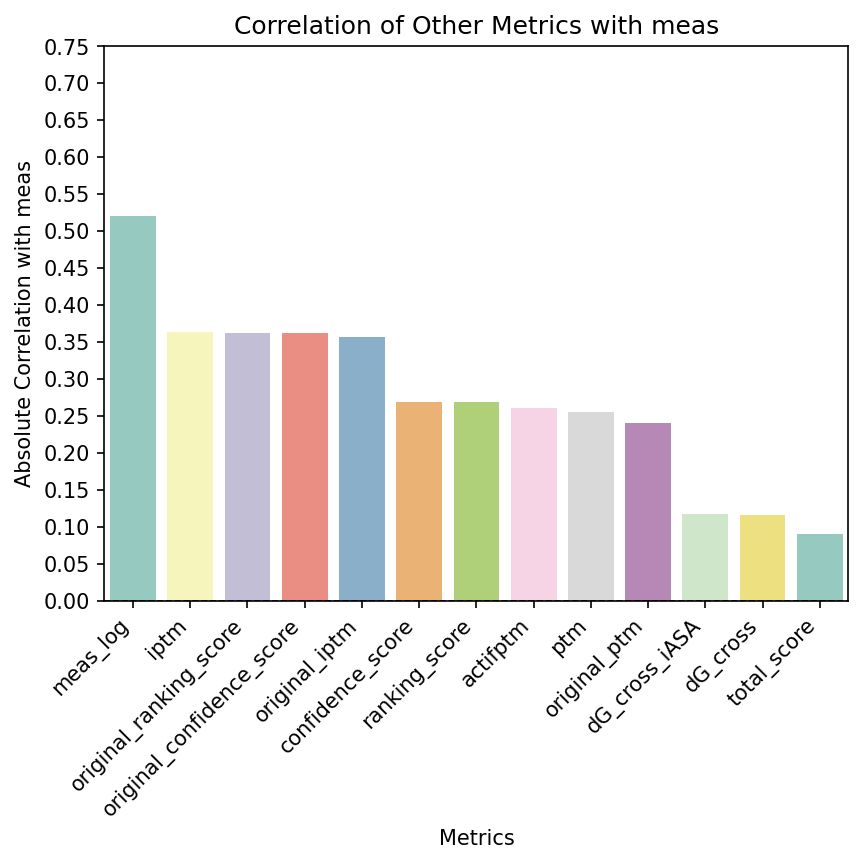

In [10]:
# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_cross_iASA", "total_score"]

# 计算 `meas` 与其他列的 Pearson 相关性，并取绝对值（将负数变正）
corr_series = df[selected_columns].corr(method="pearson")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150)
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set3", legend=False)

plt.ylabel("Absolute Correlation with meas")
plt.xlabel("Metrics")
plt.yticks(np.arange(0, 0.8, 0.05))
plt.title("Correlation of Other Metrics with meas")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

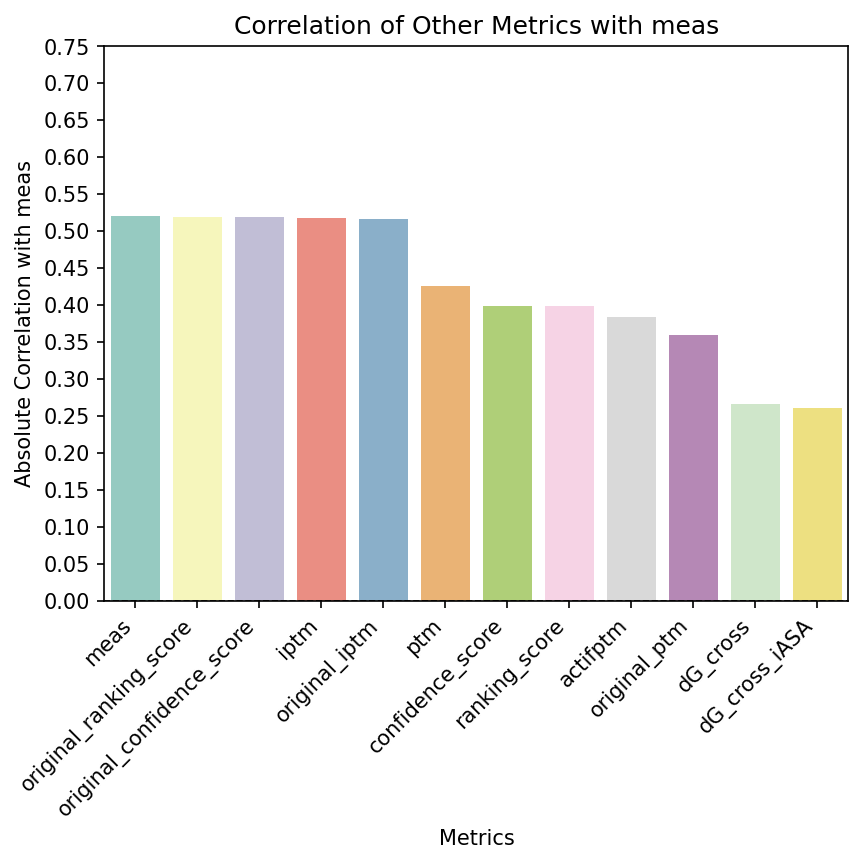

In [50]:
# 计算 `meas` 与其他列的 Pearson 相关性，并取绝对值（将负数变正）
corr_series = df[selected_columns].corr(method="pearson")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150)
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set3", legend=False)

plt.ylabel("Absolute Correlation with meas")
plt.xlabel("Metrics")
plt.yticks(np.arange(0, 0.8, 0.05))
plt.title("Correlation of Other Metrics with meas")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

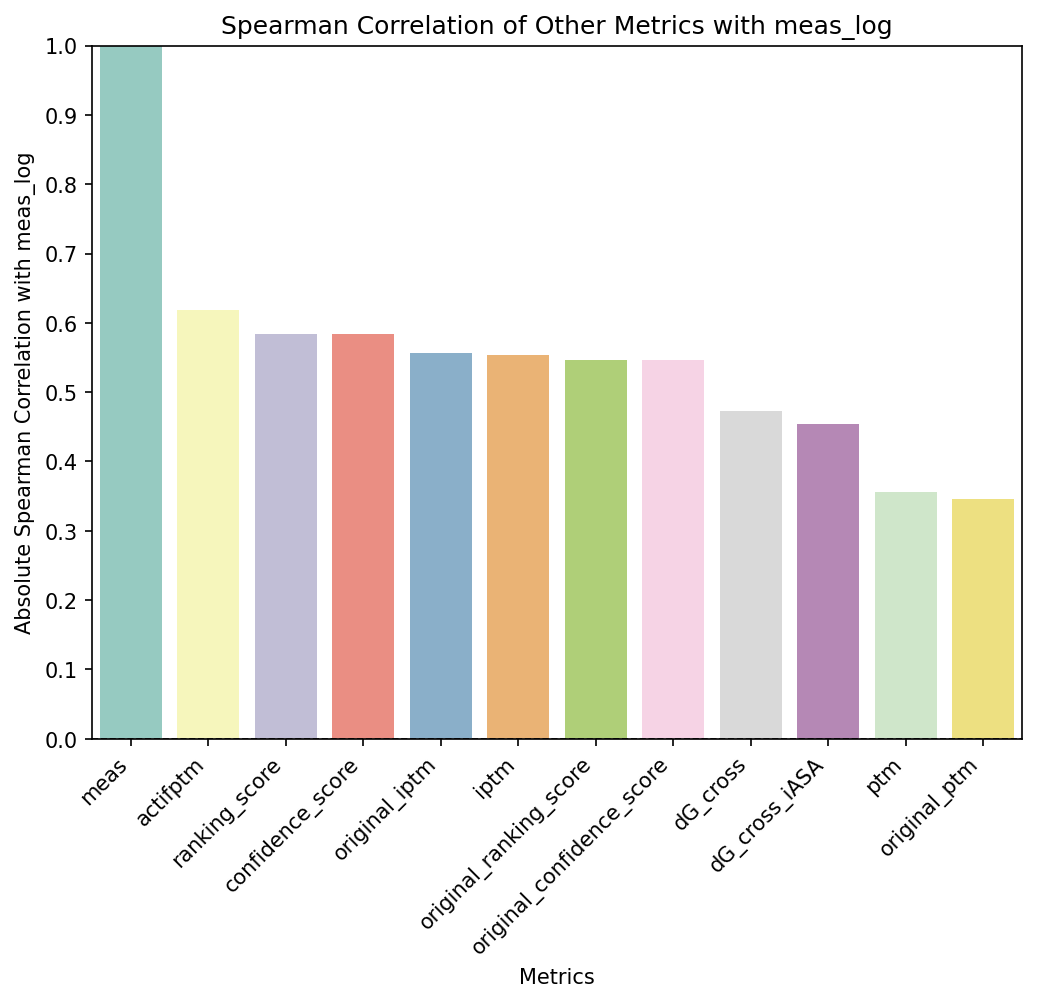

In [51]:
# 计算 `meas_log` 与其他列的 Spearman 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="spearman")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set3", legend=False)

plt.ylabel("Absolute Spearman Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Spearman Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

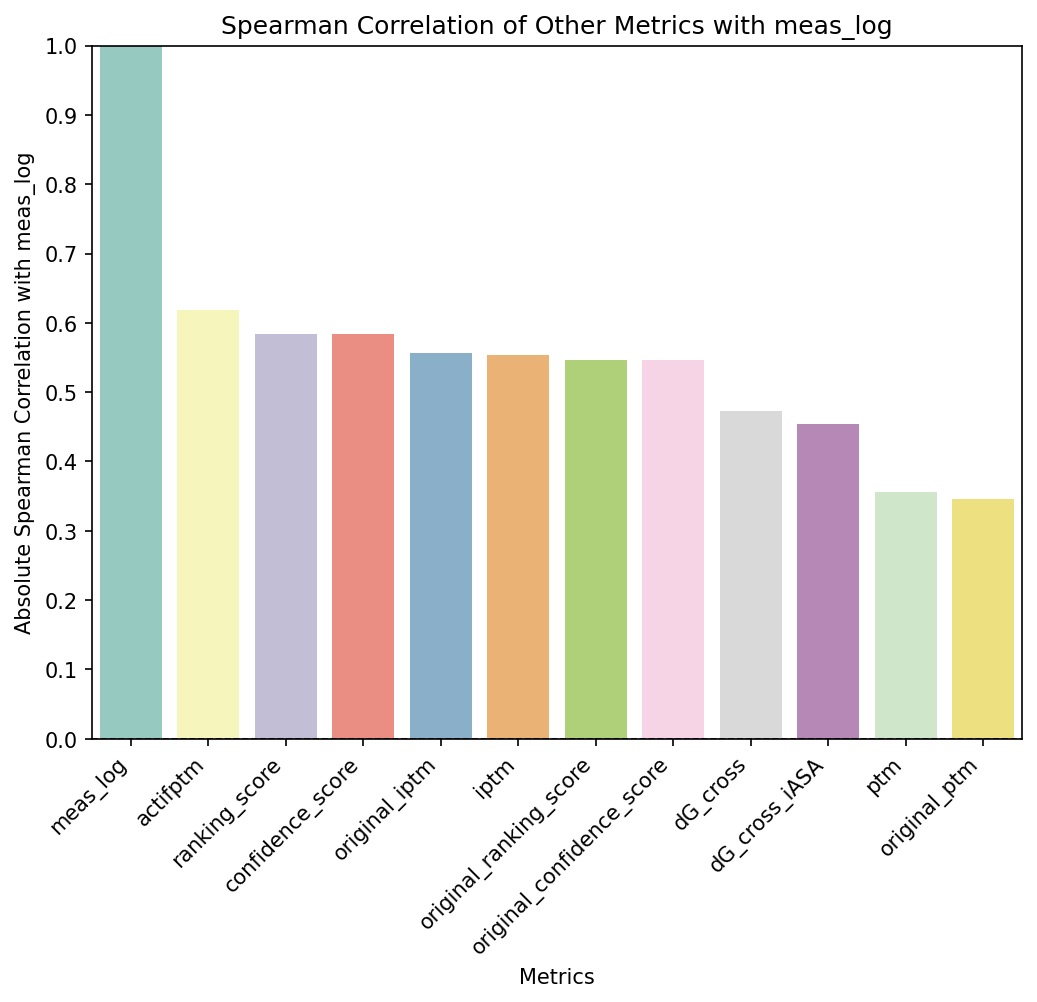

In [52]:
# 计算 `meas_log` 与其他列的 Spearman 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="spearman")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set3", legend=False)

plt.ylabel("Absolute Spearman Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Spearman Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

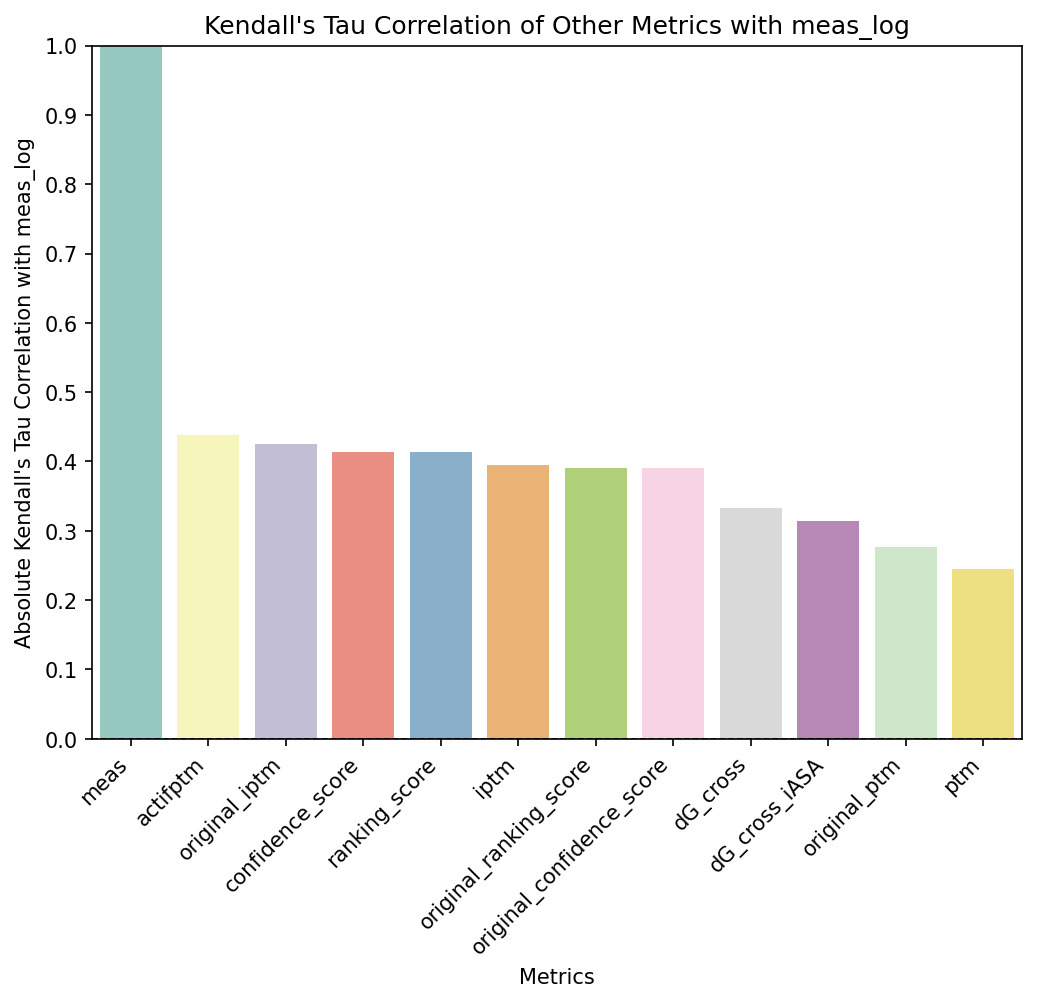

In [53]:
# 计算 `meas_log` 与其他列的 Kendall 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="kendall")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set3", legend=False)

plt.ylabel("Absolute Kendall's Tau Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Kendall's Tau Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

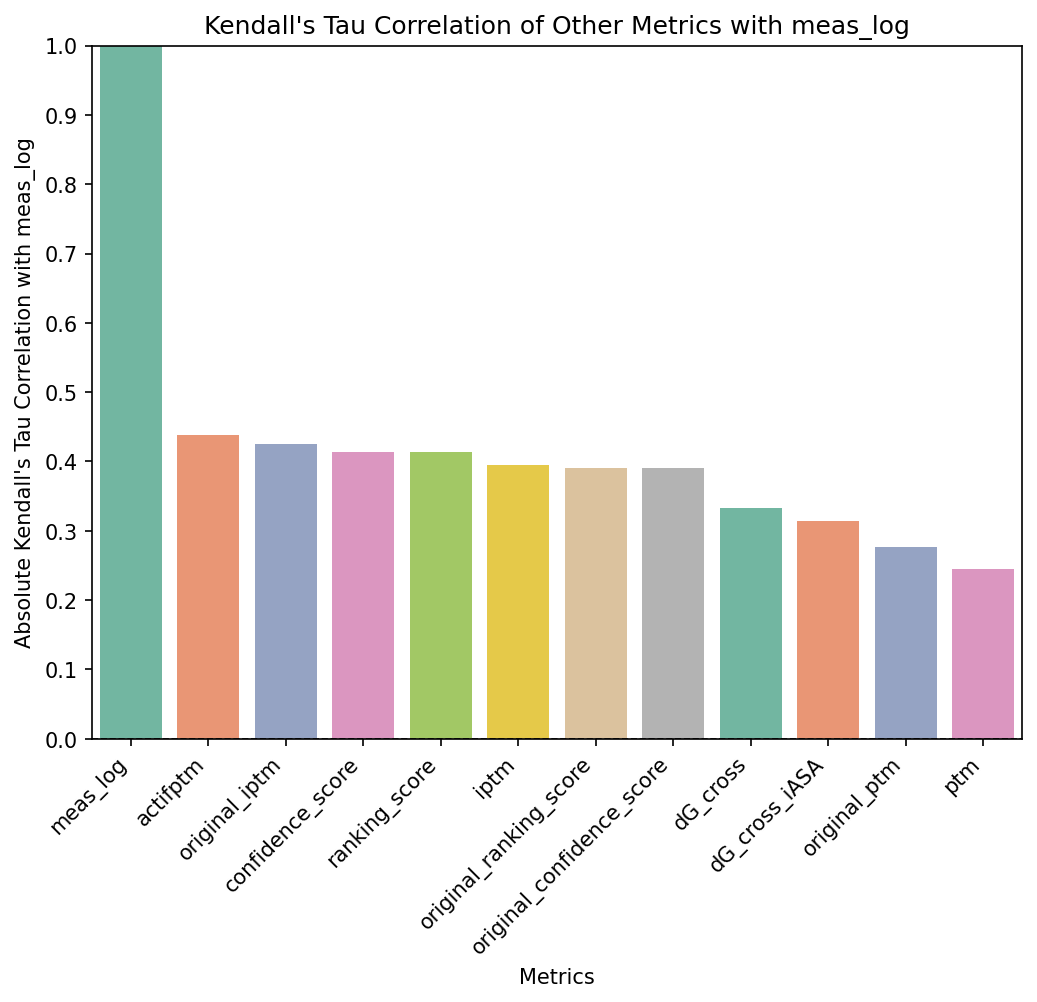

In [54]:
# 计算 `meas_log` 与其他列的 Kendall 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="kendall")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Kendall's Tau Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Kendall's Tau Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

/tmp/ipykernel_2030900/1737059594.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l1_distances.index, y=l1_distances.values, palette="Blues_r", ax=axes[0])
/tmp/ipykernel_2030900/1737059594.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(l1_distances.index, rotation=45, ha="right")
/tmp/ipykernel_2030900/1737059594.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l2_distances.index, y=l2_distances.values, palette="Reds_r", ax=axes[1])
/tmp/ipykernel_2030900/1737059594.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

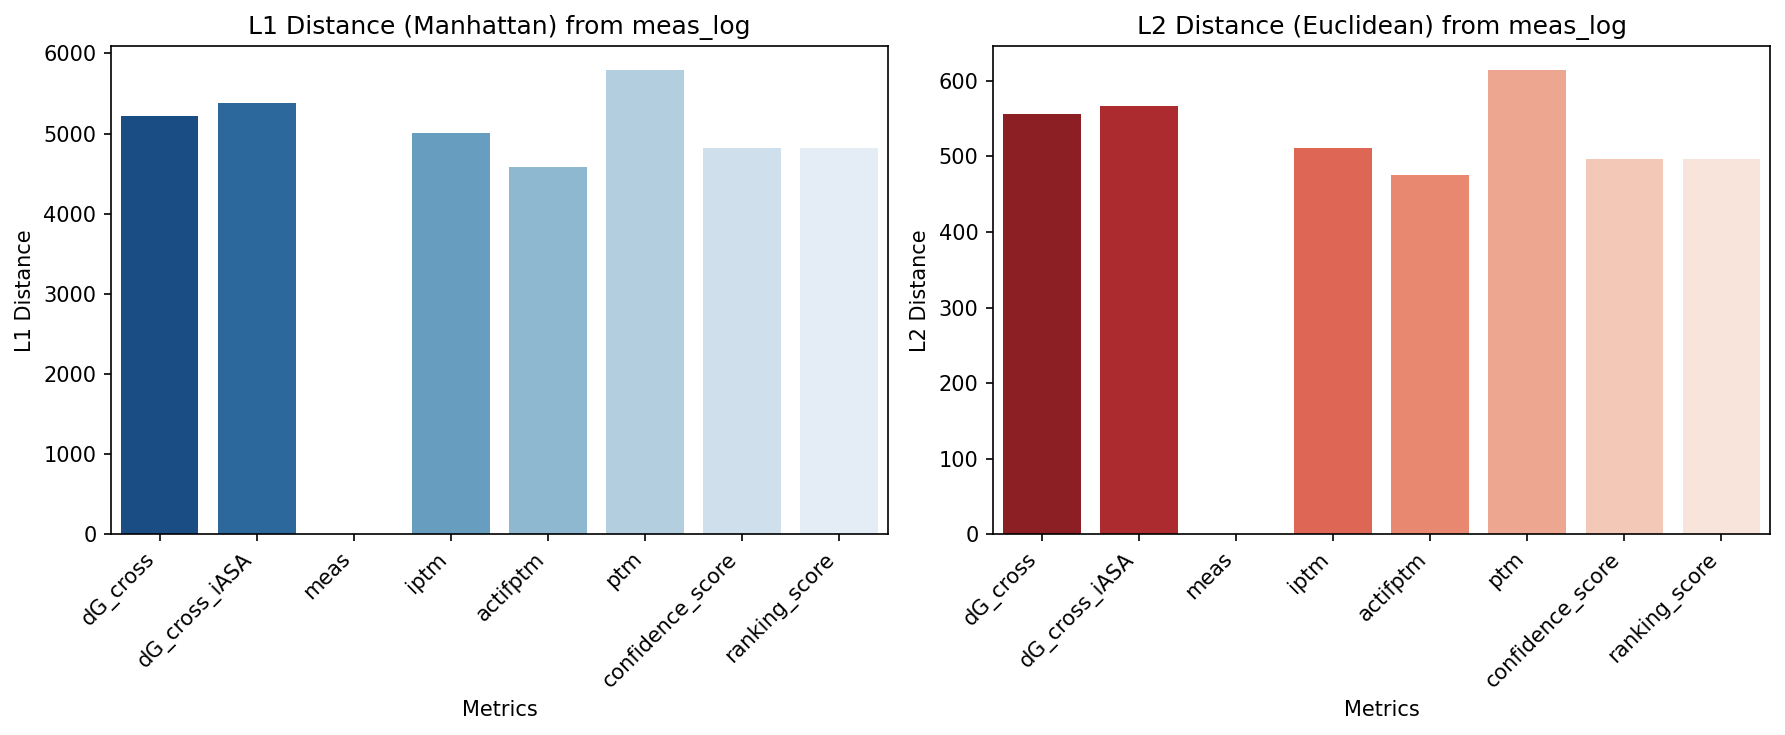

In [55]:
# 选取需要计算排名距离的列
descending_columns = [
    "iptm",
    "actifptm",
    "ptm",
    "confidence_score",
    "ranking_score",
]

ascending_columns = ["dG_cross", "dG_cross_iASA", "meas", "meas_log"]

rank_df_ascending = df[ascending_columns].rank(method="min", ascending=True)
rank_df_descending = df[descending_columns].rank(method="min", ascending=False)

selected_columns = descending_columns + ascending_columns
rank_df = pd.concat([rank_df_ascending, rank_df_descending], axis=1)

# 计算 L1（曼哈顿距离）和 L2（欧几里得距离）
l1_distances = np.abs(rank_df.subtract(rank_df["meas_log"], axis=0)).sum()
l2_distances = np.sqrt((rank_df.subtract(rank_df["meas_log"], axis=0) ** 2).sum())

# 删除 `meas_log`（自身不计算距离）
l1_distances = l1_distances.drop("meas_log")
l2_distances = l2_distances.drop("meas_log")

# 可视化 L1 和 L2 距离
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# L1 距离
sns.barplot(x=l1_distances.index, y=l1_distances.values, palette="Blues_r", ax=axes[0])
axes[0].set_title("L1 Distance (Manhattan) from meas_log")
axes[0].set_ylabel("L1 Distance")
axes[0].set_xlabel("Metrics")
axes[0].set_xticklabels(l1_distances.index, rotation=45, ha="right")

# L2 距离
sns.barplot(x=l2_distances.index, y=l2_distances.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("L2 Distance (Euclidean) from meas_log")
axes[1].set_ylabel("L2 Distance")
axes[1].set_xlabel("Metrics")
axes[1].set_xticklabels(l2_distances.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

/tmp/ipykernel_2030900/377830834.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kendall_series.index, y=kendall_series.values, palette="Purples_r")


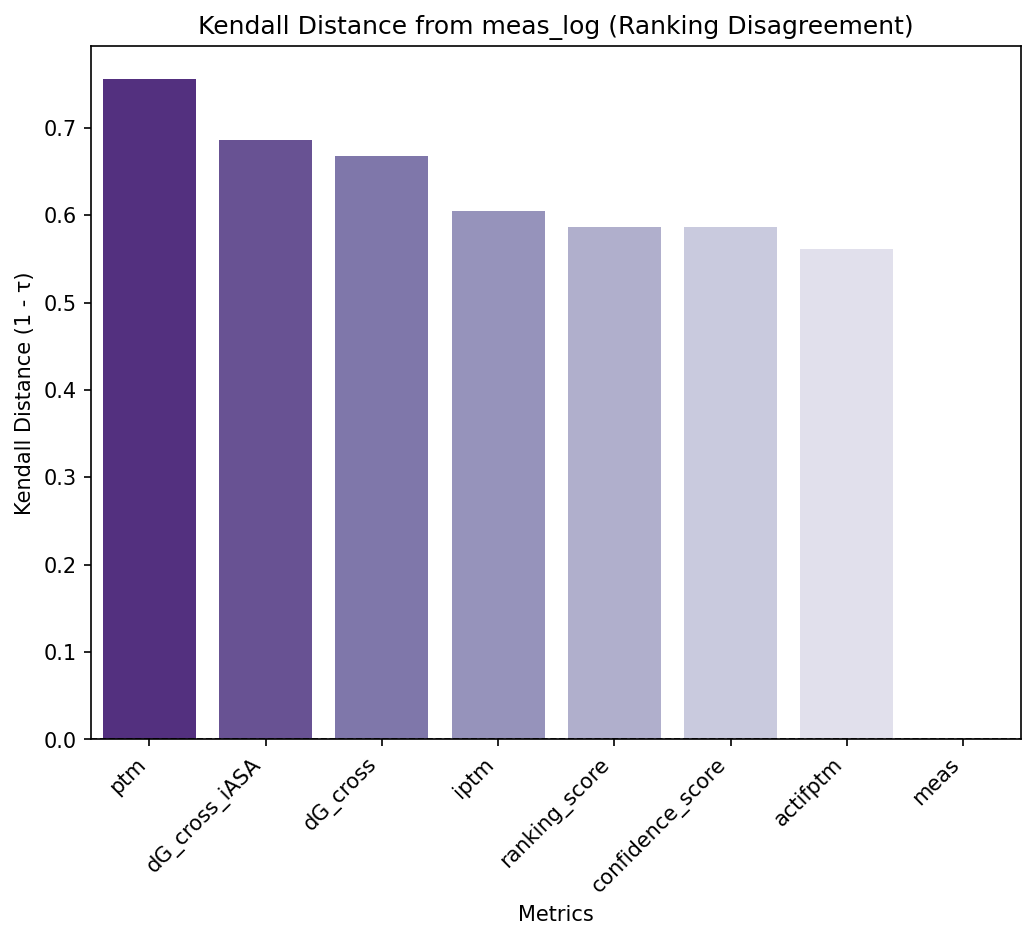

In [56]:
# 计算 Kendall 距离
kendall_distances = {}

for col in selected_columns:
    if col != "meas_log":
        tau, _ = kendalltau(rank_df["meas_log"], rank_df[col])
        # Kendall 距离 = 1 - Kendall's Tau 相关系数（因为 τ 越小表示排名变化越大）
        kendall_distances[col] = 1 - tau

# 转换为 Pandas Series 并排序
kendall_series = pd.Series(kendall_distances).sort_values(ascending=False)

# 可视化 Kendall 距离
plt.figure(figsize=(8, 6), dpi=150)
sns.barplot(x=kendall_series.index, y=kendall_series.values, palette="Purples_r")

plt.ylabel("Kendall Distance (1 - τ)")
plt.xlabel("Metrics")
plt.title("Kendall Distance from meas_log (Ranking Disagreement)")
plt.xticks(rotation=45, ha="right")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加参考线

plt.show()

In [57]:
rank_df.to_csv("./results/rank_df.csv", index=False)

In [58]:
## Enrichment Factor
def cal_enrichment_factor(df: pd.DataFrame, metric="dG_cross", top_n: int = 20, descending: bool = True) -> float:
    df = df.copy()
    
    # 定义活性分子
    df["is_active"] = df["meas"] < 10
    
    # 总体统计
    total_active = df["is_active"].sum()
    total_mols = len(df)

    if total_active == 0:
        raise ValueError("数据中没有活性分子，无法计算 EF。")
    
    # 排序（按 docking 得分，越小越好）
    df = df.sort_values(by=metric, ascending=descending)  # 更低的dG更好

    # 取 top_n
    top_df = df.head(top_n)
    top_active = top_df["is_active"].sum()
    print(top_active)
    # EF 计算
    ef = (top_active / top_n) / (total_active / total_mols)

    return ef

metrics = ["dG_cross", "dG_cross_iASA", "meas", "meas_log", "ranking_score", "original_ranking_score", "iptm", "actifptm", "ptm", "confidence_score"]
for metric in metrics:
    descending = True if metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"] else False
    ef = cal_enrichment_factor(df, metric=metric, top_n=40, descending=descending)
    print(f"{metric}: {ef}")

21
dG_cross: 1.7659090909090909
20
dG_cross_iASA: 1.6818181818181817
40
meas: 3.3636363636363633
40
meas_log: 3.3636363636363633
21
ranking_score: 1.7659090909090909
18
original_ranking_score: 1.5136363636363637
18
iptm: 1.5136363636363637
22
actifptm: 1.85
16
ptm: 1.3454545454545455
21
confidence_score: 1.7659090909090909


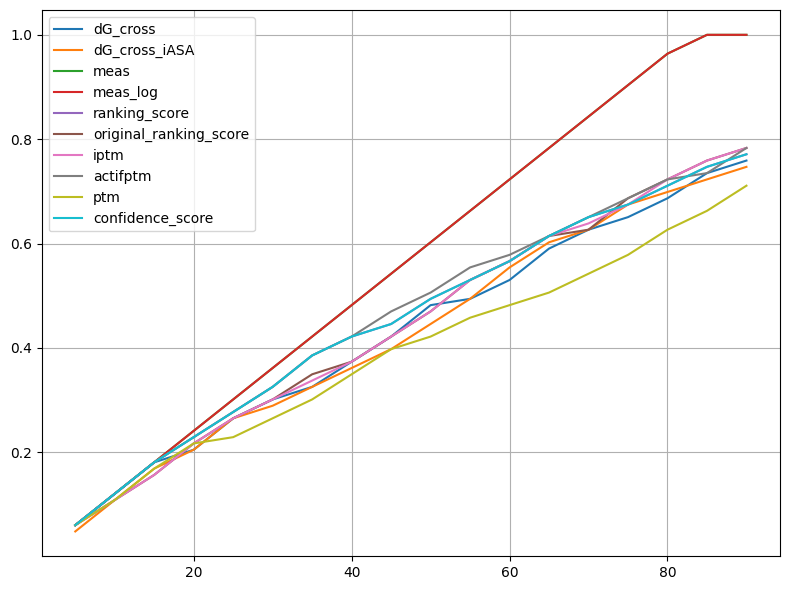

In [59]:
def plot_multiple_enrichment_curves(df, metrics, max_n=100):
    df = df.copy()
    df["is_active"] = df["meas"] < 500

    total_active = df["is_active"].sum()
    if total_active == 0:
        raise ValueError("没有活性分子，无法绘图")

    top_ns = np.arange(5, total_active + 11, 5)

    plt.figure(figsize=(8, 6))

    for metric in metrics:
        descending = True if metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"] else False
        df_sorted = df.sort_values(by=metric, ascending= descending)
        enrichments = []
        for n in top_ns:
            top_active = df_sorted.head(n)["is_active"].sum()
            enrichments.append(top_active / total_active)

        plt.plot(top_ns, enrichments, label=metric)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_multiple_enrichment_curves(df, metrics)

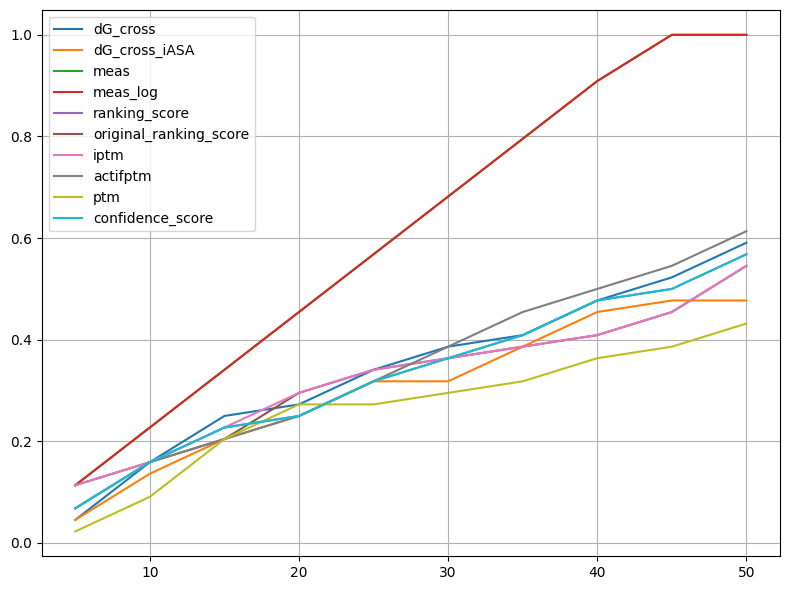

In [60]:
def plot_multiple_enrichment_curves(df, metrics, max_n=100):
    df = df.copy()
    df["is_active"] = df["meas"] < 10

    total_active = df["is_active"].sum()
    if total_active == 0:
        raise ValueError("没有活性分子，无法绘图")

    top_ns = np.arange(5, total_active + 11, 5)

    plt.figure(figsize=(8, 6))

    for metric in metrics:
        descending = True if metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"] else False
        df_sorted = df.sort_values(by=metric, ascending= descending)
        enrichments = []
        for n in top_ns:
            top_active = df_sorted.head(n)["is_active"].sum()
            enrichments.append(top_active / total_active)

        plt.plot(top_ns, enrichments, label=metric)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_multiple_enrichment_curves(df, metrics)